# The Rayleigh-Plesset equation and its modifications

#### Tan Beng Hau, Cavitation Lab

In this notebook I show a few derivations of the Rayleigh-Plesset equation. Most of the derivations come from a very nice set of notes written by TG Leighton. I show two ways to derive the R-P equation – from integrating the Euler equation, and using an energy balance. I also show some extensions to the classical theory, such as the effect of gas pressure and the influence of finiteness in the cavitation problem.

## Derivation by integrating the Euler equation

A spherical bubble of radius $R$ in an incompressible liquid of infinite extent will satisfy a potential of the form

$$ \phi = \frac{A}{r}, $$

where $r$ is the radial coordinate. The velocity satisfies $u_r = -A/r^2$, which at the boundary must be $u_r(R) = \dot{R}$. Therefore, $A = -R^2 \dot{R}$. Therefore, the velocity potential around a bubble must be

$$ \phi = - \frac{R^2 \dot{R}}{r}. $$

For a steady flow,

$$ \rho \left( \frac{\partial {\bf u}}{\partial t} + {\bf u} \cdot \nabla{\bf u}\right) = -\nabla p -\rho \nabla \Phi, $$

where $\Phi$ is an assumed potential for the body forces. Note the identity ${\bf u} \cdot \nabla {\bf u} = \nabla (\frac{1}{2}{\bf u} \cdot {\bf u}) - {\bf u} \times {\bf \omega}$, which gives 

$$ -{\bf u} \times \omega = -\nabla \left( \frac{1}{2}{\bf u}^2 + \frac{p}{\rho} + \Phi \right) - \frac{\partial {\bf u}}{\partial t}. $$

For an irrotational flow, ${\bf u} =\nabla \phi$ and $\omega = 0$, 

$$ \nabla \left(\frac{\partial \phi}{\partial t} + \frac{p}{\rho} + \Phi + \frac{1}{2}{\bf u}^2 \right) = 0. $$

Integrating throughout gives us the *unsteady Bernoulli equation* 

$$ \frac{\partial \phi}{\partial t} + \frac{p}{\rho} + \Phi + \frac{1}{2}{\bf u}^2 = \frac{P(t)}{\rho}, $$

where $P$ is the static pressure some distance from the bubble. From the velocity potential equation we have 

$$ {\bf u}^2 = R^4 \frac{\dot{R}^2}{r^4}, $$

$$ \frac{\partial \phi}{\partial t} = - \frac{1}{r} \left( 2R \dot{R} + R^2 \ddot{R} \right). $$

To determine the equation of motion of the bubble radius, we take all quantities at $r=R$, and neglect the body forces to obtain 

$$ \frac{\partial \phi}{\partial t} \bigg\vert_{r=R} = -  2 \dot{R} - R \ddot{R},$$

$$ {\bf u}^2 = \dot{R}^2. $$

Rearranging terms gives the Rayleigh-Plesset equation

$$ \frac{p(R) - P(t)}{\rho} = \frac{3}{2}\dot{R} + R \ddot{R}. $$

## Numerical solution

This second order ODE can be written as 

$$ y_0 = R, $$

$$ y_1 = \frac{dR}{dt}, $$

and hence

$$ \frac{dy_0}{dt} = y_1, $$

$$ \frac{dy_1}{dt} = - \frac{1}{y_0}\left( \frac{P_0}{\rho} + \frac{3}{2}y_1^2 \right).$$

In the numerical solution it is probably better to use a stiff solver, since the solution exhibits sharp kinks. Here we use the stiff `bdf` method with the `vode` solver. I got this code from my boss, so it should be correct.

In [2]:
from __future__ import division
from scipy import *
from matplotlib.pyplot import *
from scipy import integrate
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # for those with HD screens

In [54]:
rho = 1e3
p0 = 1e5
Rmax = 1e-3
tend = 0.914*Rmax*sqrt(rho/p0) # estimate of the collapse time
numSteps = 1000

def solveRP(rho, p0, Rmax, tend, numSteps):
    
    def rp(t,y):
        n=len(y)
        dydt=np.zeros((n,1))
        dydt[0]= y[1]
        dydt[1]= (-p0/rho-3./2.*y[1]*y[1])/y[0]
        return dydt

    t = linspace(0, tend, numSteps)
    ode = integrate.ode(rp).set_integrator('vode', method ='bdf')
    ode.set_initial_value([Rmax, 0], 0)

    # Vectors
    t = linspace(0, tend, numSteps)
    r = zeros_like(t)
    r[0] = Rmax
    dt = (tend - 0)/numSteps

    k = 1
    while ode.successful() and k < numSteps:
        ode.integrate(ode.t + dt)
        t[k] = ode.t
        r[k] = ode.y[0]
        k += 1
        
    return t,r

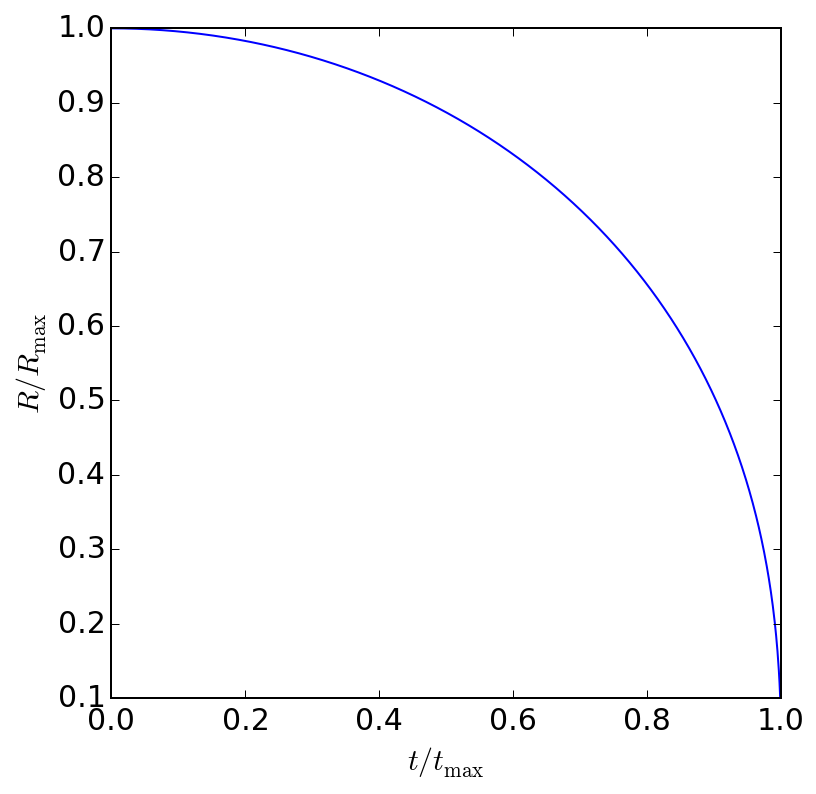

In [25]:
t, r = solveRP(rho, p0, Rmax, tend, numSteps)
figure(figsize=(6,6))
plot(t/tend,r/Rmax)
rcParams['font.size']=15
xlabel('$t/t_{\\rm max}$')
ylabel('$R/R_{\\rm max}$')

## Modifications to the Rayleigh-Plesset equation

Cavitation bubbles generated by lasers are created by a boiling process, and the gas pressure is larger than atmospheric pressure. In this case, the gas pressure is assumed polytropic, and the R-P equation becomes

$$ \frac{3}{2}\dot{R} + R \ddot{R} =\frac{ p_0 (R_0/R)^\gamma - p_0 - P(t)}{\rho},$$

where $p_0$ is the initial gas pressure, and $\gamma$ is the polytropic exponent. In this example, I have set the bubble to have an initial pressure of 10 atmospheres, so rather than collapse immediately, the bubble grows first.

In [34]:
rho = 1e3
p0 = 1e5
pbub = 1e6
Rmax = 1e-3
tend = 0.914*Rmax*sqrt(rho/p0)
numSteps = 1000
print tend

def solveRPPoly(rho, p0, Rmax, tend, numSteps):
    
    def rp(t,y):
        n=len(y)
        dydt=np.zeros((n,1))
        dydt[0]= y[1]
        dydt[1]= (pbub*(Rmax/y[0])**3/rho-p0/rho-3./2.*y[1]*y[1])/y[0]
        return dydt

    t = linspace(0, tend, numSteps)
    ode = integrate.ode(rp).set_integrator('vode', method ='bdf')
    ode.set_initial_value([Rmax, 0], 0)

    # Vectors
    t = linspace(0, tend, numSteps)
    r = zeros_like(t)
    r[0] = Rmax
    dt = (tend - 0)/numSteps

    k = 1
    while ode.successful() and k < numSteps:
        ode.integrate(ode.t + dt)
        t[k] = ode.t
        r[k] = ode.y[0]
        k += 1
        
    return t,r

9.14e-05


(0, 3.3366967296646051)

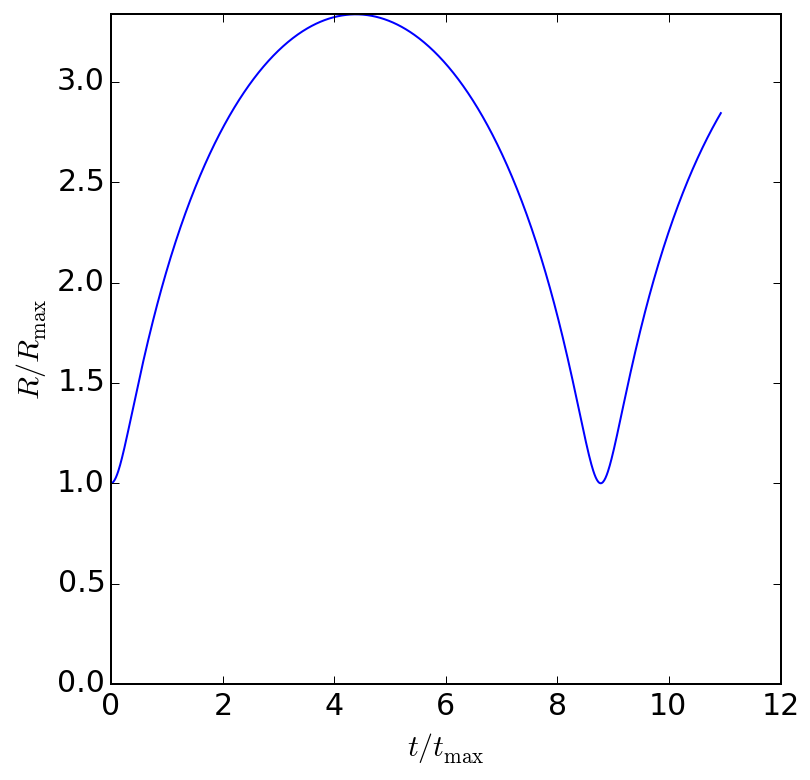

In [45]:
t1, r1 = solveRPPoly(rho, p0, Rmax, 1e-3, numSteps)

figure(figsize=(6,6))
plot(t1/tend,r1/Rmax)
rcParams['font.size']=15
xlabel('$t/t_{\\rm max}$')
ylabel('$R/R_{\\rm max}$')
ylim([0, max(r1)/Rmax])

## Derivation of the Rayleigh-Plesset equation from an energy balance

From first principles, assuming spherical symmetry about the bubble allows us to assume that the fluid velocity satisfies

$$ u(r,t) = \frac{R^2 \dot{R}}{r^2}, $$

where $u(R,t) = \dot{R}$. Assume that a bubble of radius $R$ is growing from an overpressure, say due to vaporisation. The kinetic energy exerted by the expanding bubble is

$$ E_k = \frac{1}{2}\rho \int_R^\infty 4\pi r^2 u^2 dr = 2\pi \rho R^3 \dot{R}^2, $$

while the work done on the bubble (the signs are arranged in a way that resists the expansion) is

$$ E_p = \int p dV = \int_{R_0}^R (p_L - p_\infty) 4\pi R^2 dR = \frac{4}{3}\pi
\rho(R^3-R_0^3) (p_L - p_\infty). $$

Conservation of energy states that 

$$ E_p + E_k = 0. $$

Taking the time derivatives,

$$ 2\pi\rho (3R^2 \dot{R}^2 + 2R^3\dot{R}\ddot{R}) = 4\pi R^2 \dot{R} (p_L - p_\infty) $$

Cancel out throughout by $2\pi \rho R^2 \dot{R}$, 

$$ \frac{3}{2} \dot{R} +  R \ddot{R} = \frac{(p_L - p_\infty)}{\rho}. $$

## The Rayleigh-Plesset equation in a water drop: finiteness correction

I'm not very sure about this section – there may be mistakes in the derivation, or it could be  wrong, but I think that it is worth exploring. In the classical case, the kinetic energy term is integrated to infinity, since the cavitation problem occurs in an infinite extent of liquid. If we are solving the same problem for cavitation in a finite mass of liquid, the boundary conditions should change. Assume a cavitation bubble develops within a water drop with an initial radius $R_{\rm d,0}$. We take it that the liquid is incompressible. Then the radius of the drop varies as

$$ \frac{4}{3}\pi R_{\rm d}^3 = \frac{4}{3}\pi R^3 + \frac{4}{3}\pi R_{\rm d, 0}^3. $$

We can therefore make the substitution 

$$ R^3 +   R_{\rm d,0}^3 = R_{\rm d}^3. $$

Due to the finite dimension of the water drop (the classical derivation assumes that the liquid is infinite in extent), the kinetic energy is

$$ E_k = \frac{1}{2}\rho \int_R^{R_d} 4\pi r^2 u^2 dr =\frac{1}{2}\rho \int_R^{R_d} 4\pi r^2 \frac{R^4 \dot{R}^2}{r^4} dr.  $$

$$ \begin{align} E_k &= 2\pi\rho \dot{R}^2 R^4 \left[ - \frac{1}{r} \right]_{r=R}^{r=R_d} \\ &=2\pi\rho \dot{R}^2 R^4 \left( \frac{1}{R} - \frac{1}{R_d} \right) \\ &= 2\pi\rho \dot{R}^2 R^3 \left( 1 - \frac{R}{R_d} \right).\end{align}$$

The work done on the bubble remains the same:

$$ E_p = \int p dV = \int_{R_0}^R (p_L - p_\infty) 4\pi R^2 dR = \frac{4}{3}\pi
\rho(R^3-R_0^3) (p_L - p_\infty). $$

Balancing $E_k$ and $E_p$ and taking derivatives w.r.t. $r$

$$  \rho \left( 3R^2 \dot{R}^3 + 2 \dot{R} R^3 \ddot{R} -\frac{4 R^3 \dot{R}^3}{R_d} - \frac{2 R^4 \dot{R} \ddot{R} }{R_d} \right) = 2R^2 \dot{R} (p_L - p_\infty). $$

$$ \frac{3}{2}\dot{R}^2 +   R \ddot{R} -\frac{2 R \dot{R}^2}{R_d} - \frac{R^2 \ddot{R} }{R_d}  =  \frac{(p_L - p_\infty)}{\rho}. $$

For the purpose of the numerical solution it is beneficial to rewrite this as

$$ \ddot{R} R \left( 1 - \frac{R}{R_d} \right) = - \dot{R}^2 \left(\frac{3}{2} - \frac{2 R}{R_d} \right) + \frac{(p_L - p_\infty)}{\rho}. $$

Note that if we take the limit that the drop is infinite in extent i.e. $R_p \rightarrow\infty$ we simply retrieve the classical Rayleigh-Plesset equation. To test how finiteness affects Rayleigh-Plesset, let us assume that the drop is 5 times the radius of the bubble. 

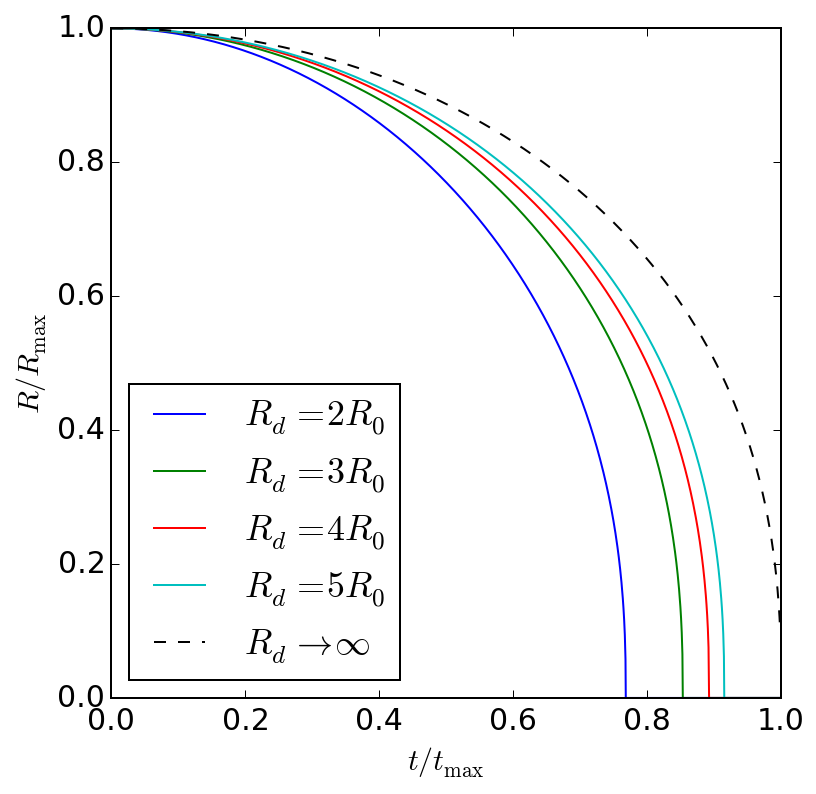

In [57]:
rho = 1e3
p0 = 1e5
Rmax = 1e-3
Rdrop = 5*Rmax
tend = 0.914*Rmax*sqrt(rho/p0)
numSteps = 1000

def solveRPFinite(rho, p0, Rmax, Rdrop, tend, numSteps):
    
    def rpFinite(t,y):
        n=len(y)
        dydt=np.zeros((n,1))
        
        div1 = y[0]*(1 - y[0]/Rdrop)
        
        dydt[0]= y[1]
        dydt[1]= (-p0/rho-3./2.*y[1]*y[1] + 2*y[0]*y[1]*y[1]/Rdrop)/div1
        return dydt

    t = linspace(0, tend, numSteps)
    ode = integrate.ode(rpFinite).set_integrator('vode', method ='bdf')
    ode.set_initial_value([Rmax, 0], 0)

    # Vectors
    t = linspace(0, tend, numSteps)
    r = zeros_like(t)
    r[0] = Rmax
    dt = (tend - 0)/numSteps

    k = 1
    while ode.successful() and k < numSteps:
        ode.integrate(ode.t + dt)
        t[k] = ode.t
        r[k] = ode.y[0]
        k += 1
        
    return t,r

t, r = solveRPFinite(rho, p0, Rmax, 2*Rmax, tend, numSteps)
t1, r1 = solveRPFinite(rho, p0, Rmax, 3*Rmax, tend, numSteps)
t2, r2 = solveRPFinite(rho, p0, Rmax, 4*Rmax, tend, numSteps)
t3, r3 = solveRPFinite(rho, p0, Rmax, 5*Rmax, tend, numSteps)
tc, rc = solveRP(rho, p0, Rmax, tend, numSteps)

figure(figsize=(6,6))
plot(t/tend,r/Rmax, label='$R_d = 2 R_0$')
plot(t1/tend,r1/Rmax, label='$R_d = 3 R_0$')
plot(t2/tend,r2/Rmax, label='$R_d = 4 R_0$')
plot(t3/tend,r3/Rmax, label='$R_d = 5 R_0$')
plot(tc/tend,rc/Rmax, 'k--', label='$R_d \\rightarrow \\infty$')

rcParams['font.size']=15
legend(loc='lower left')
xlabel('$t/t_{\\rm max}$')
ylabel('$R/R_{\\rm max}$')

The main takeaway is that cavitation in confined boundaries reduces the collapse time somewhat. 